# Spritz MBHB search + imputation (time-domain approach)

Let's try to  replicate `MBHB-search-dev-globe.ipynb` with time-domain data and with Spritz data (MBHB-1 dataset).

E Castelli - 2022

## Table of contents

0. Settings and package import
1. Load time-domain LDC data
2. Build orthogonal TDI combinations
3. Data pre-processing before gap-imputation
4. Gap imputation with custom gaps
    1. noise-only `n` data
    2. noise + signal `n + s` data
5. Analysis of Spritz data

## 0. Settings and package import

In [306]:
# Python standard packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import scipy.signal as signal
import h5py
import scipy.signal
import pandas as pd
import xarray as xr
from cycler import cycler
import time

In [280]:
# Custom LISA Data Analysis packages 
from ldc.lisa.noise import get_noise_model
from ldc.common import tools
from ldc.common.constants import ldc_cosmo as cosmo
from ldc.common.series import TimeSeries, FrequencySeries, TDI
from ldc.common.tools import compute_tdi_snr, window
from ldc.lisa.orbits import Orbits
from ldc.lisa.projection import ProjectedStrain
from ldc.lisa.noise import AnalyticNoise, get_noise_model
from ldc.waveform.lisabeta import FastBHB

import lisabeta.lisa.ldcnoise as ldcnoise
from bayesdawn import datamodel, psdmodel

In [3]:
# define function to print all attributes of hdf5 file recursively
def print_attrs(name, obj):
    shift = name.count('/') * '    '
    print(shift + name)
    for key, val in obj.attrs.items():
        print(shift + '    ' + f"{key}: {val}")

## 1. Load time-domain LDC data

We are currently interested only in the impact of gaps on the Spritz MBHB-1 dataset. In order to do that, we separate the effect of glitches from the effect of gaps in the Spritz data.

### 1.1. Download and access data

Download LDC 2b *Spritz* MBHB-1 data from the LDC official website (https://lisa-ldc.lal.in2p3.fr/challenge2b) and save them to the `./data/` folder.

In [4]:
# import data
fname = './data/LDC2_spritz_mbhb1_training_v1.h5'
# open file with h5py
fid = h5py.File(fname)
# print all dataset attributes
# fid.visititems(print_attrs)

#### 1.1. Import the existing TDI datasets

- TDI dataset `obs` containing `noise + signal + artifacts` (gaps + glitches)
- TDI dataset `clean` containing `noise + signal`
- TDI dataset `sky` containing `signal`
- TDI dataset `noisefree` containing `signal + artifacts` (gaps + glitches)

In [5]:
# load xarray dataset containing TDI combinations from LDC dataset
tdi_ts = fid['obs/tdi'][()].squeeze()
# clean data only noise + signal
tdi_clean = fid["clean/tdi"][()].squeeze()
# no noise no glitches, only signal
tdi_sky = fid["sky/tdi"][()].squeeze()
# no noise only glitches and MBHB data
tdi_nonoise = fid["noisefree/tdi"][()].squeeze()

#### 1.2. Build the missing TDI dataset
- TDI dataset containing `noise`
- TDI dataset containing `noise + signal + gaps`

In [6]:
# set up dataset constant values
skip = 100 
# skipb = 100 
ndata = len(tdi_ts[skip:])
dt = tdi_ts['t'][1]-tdi_ts['t'][0]
fs = 1.0/dt

print('skip','ndata','dt', 'fs',sep='\t',end='\n------------------------------\n')
print(skip,ndata,dt, fs,sep='\t')

skip	ndata	dt	fs
------------------------------
100	535580	5.0	0.2


In [7]:
# generate noise-only dataset
tdi_noise = np.copy(tdi_clean)
for tdi in tdi_clean.dtype.names[1:]:
    tdi_noise[tdi] = tdi_clean[tdi] - tdi_sky[tdi]

In [8]:
# find all data points included in the gaps
gaps = tdi_ts["t"][np.isnan(tdi_ts["X"])]
# find start times of gaps by taking first point and the point for which 
# the difference between two subsequent samples is more than dt
start = np.hstack([np.array([gaps[0]]), (gaps[1:])[gaps[1:]-gaps[:-1]>dt]])
# same thing with endpoints, but reversed
end = np.hstack([(gaps[:-1])[gaps[1:]-gaps[:-1]>dt], np.array([gaps[-1]])])
# get the indeces for the gaps
gaps_indices = np.vstack([start, end])

# generate gapped dataset
tdi_gapped = np.copy(tdi_clean)
tdi_noise_gapped = np.copy(tdi_noise)
tdi_sky_gapped = np.copy(tdi_sky)
for tdi in tdi_gapped.dtype.names[1:]:
    tdi_gapped[tdi][np.isnan(tdi_ts["X"])] = np.nan
    tdi_noise_gapped[tdi][np.isnan(tdi_ts["X"])] = np.nan
    tdi_sky_gapped[tdi][np.isnan(tdi_ts["X"])] = np.nan

#### 1.3. Plot imported data:
- Datasets containing NO noise artifacts: `n+s`, `s`, `n`
- Dataset with artifacts: `n+s+g+gl`, `n+s+g`,`s+g+gl`
    
Useful LDC-provided resources and code bits to importing Spritz data taken from here: https://gitlab.in2p3.fr/LISA/LDC/-/blob/develop/notebooks/LDC2b-Spritz.ipynb

Text(0.5, 0.98, 'TDI X time-series and noise spectra')

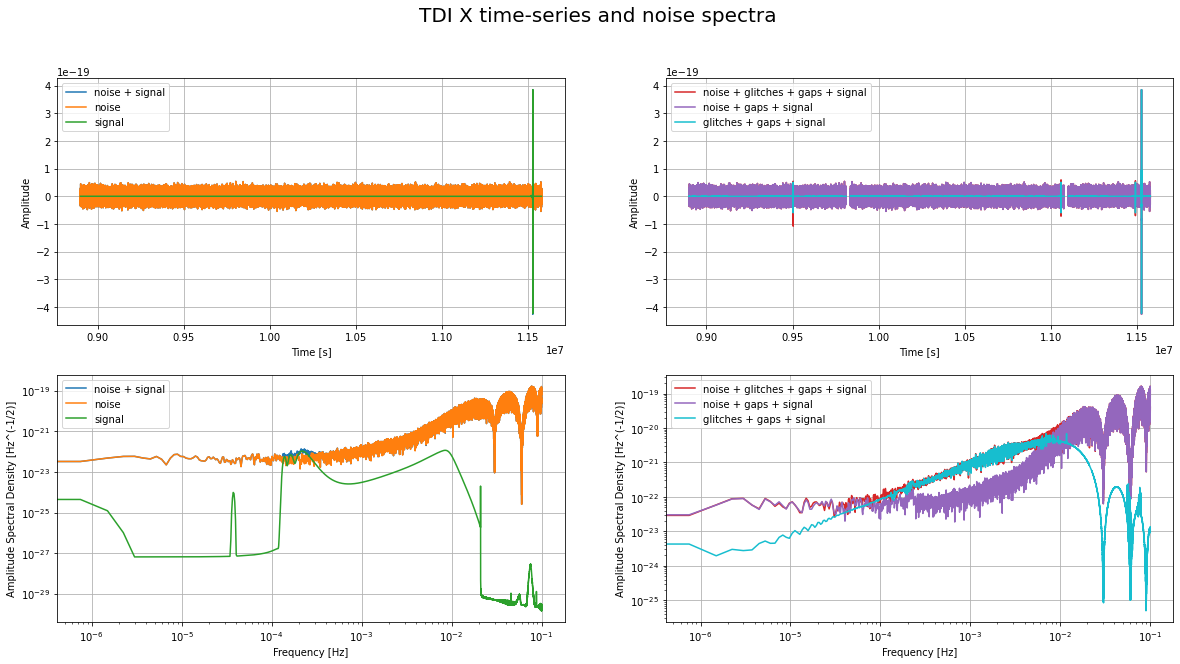

In [9]:
# plot TDI X time-series and noise spectra for all different configurations

fig, ax = plt.subplots(2, 2, figsize=(20,10))
# top left canvas
ax[0][0].plot(tdi_clean['t'][skip:], tdi_clean["X"][skip:], label = 'noise + signal')
ax[0][0].plot(tdi_noise['t'][skip:], tdi_noise["X"][skip:], label='noise')
ax[0][0].plot(tdi_sky['t'][skip:], tdi_sky["X"][skip:], label='signal')
ax[0][0].set_ylabel("Amplitude")
ax[0][0].set_xlabel("Time [s]")
ax[0][0].grid()
ax[0][0].legend()
# top right canvas
ax[0][1].plot(tdi_ts['t'][skip:], tdi_ts["X"][skip:], label='noise + glitches + gaps + signal', color='tab:red')
ax[0][1].plot(tdi_gapped['t'][skip:], tdi_gapped["X"][skip:], label='noise + gaps + signal', color='tab:purple')
ax[0][1].plot(tdi_nonoise['t'][skip:], tdi_nonoise["X"][skip:], label='glitches + gaps + signal', color='tab:cyan')
ax[0][1].set_ylabel("Amplitude")
ax[0][1].set_xlabel("Time [s]")
ax[0][1].grid()
ax[0][1].legend()
# bottom left canvas
f, psdX =  scipy.signal.welch(tdi_clean["X"][skip:], fs=1.0/dt, window='nuttall', nperseg=ndata/2)
ax[1][0].loglog(f, np.sqrt(psdX),label = 'noise + signal')
f, psdX =  scipy.signal.welch(tdi_noise["X"][skip:], fs=1.0/dt, window='nuttall', nperseg=ndata/2)
ax[1][0].loglog(f, np.sqrt(psdX),label = 'noise')
f, psdX =  scipy.signal.welch(tdi_sky["X"][skip:], fs=1.0/dt, window='nuttall', nperseg=ndata/2)
ax[1][0].loglog(f, np.sqrt(psdX),label = 'signal')
ax[1][0].set_ylabel("Amplitude Spectral Density [Hz^(-1/2)]")
ax[1][0].set_xlabel("Frequency [Hz]")
ax[1][0].grid()
ax[1][0].legend()
# bottom right canvas
tdix_wo_nan = tdi_ts["X"].copy()
tdix_wo_nan[np.isnan(tdi_ts['X'])] = 0 # set to 0 to compute PSD
f, psdX =  scipy.signal.welch(tdix_wo_nan[skip:], fs=1.0/dt, window='nuttall', nperseg=ndata/2)
ax[1][1].loglog(f, np.sqrt(psdX),label = 'noise + glitches + gaps + signal', color='tab:red')

tdigapped_wo_nan = tdi_gapped["X"].copy()
tdigapped_wo_nan[np.isnan(tdi_ts['X'])] = 0 # set to 0 to compute PSD
f, psdX =  scipy.signal.welch(tdigapped_wo_nan[skip:], fs=1.0/dt, window='nuttall', nperseg=ndata/2)
ax[1][1].loglog(f, np.sqrt(psdX),label = 'noise + gaps + signal', color='tab:purple')

tdinoise_wo_nan = tdi_nonoise["X"].copy()
tdinoise_wo_nan[np.isnan(tdi_ts['X'])] = 0 # set to 0 to compute PSD
f, psdX =  scipy.signal.welch(tdinoise_wo_nan[skip:], fs=1.0/dt, window='nuttall', nperseg=ndata/2)
ax[1][1].loglog(f, np.sqrt(psdX),label = 'glitches + gaps + signal', color='tab:cyan')

ax[1][1].set_ylabel("Amplitude Spectral Density [Hz^(-1/2)]")
ax[1][1].set_xlabel("Frequency [Hz]")
ax[1][1].grid()
ax[1][1].legend()

plt.suptitle('TDI X time-series and noise spectra',fontsize=20)
# fig.tight_layout()

#### 1.5 Let's take a look at the impact of gaps on the noise spectrum

Text(0.5, 0.98, 'TDI X time-series and noise spectra')

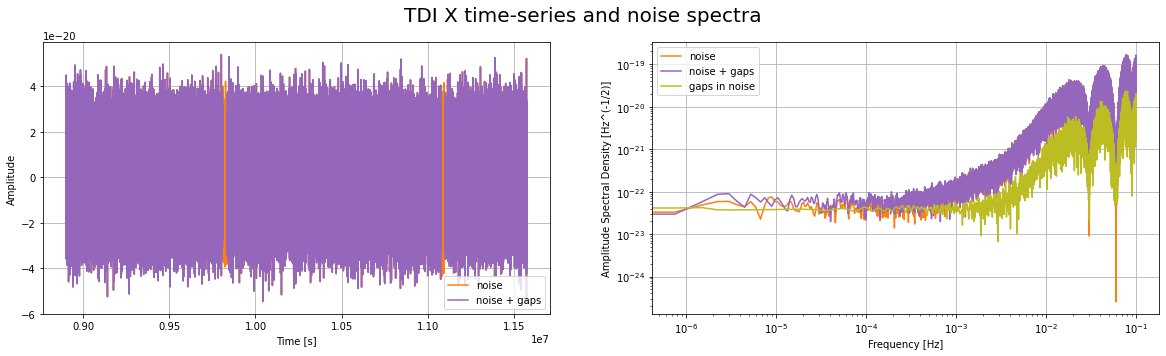

In [10]:
# plot TDI X
fig, ax = plt.subplots(1, 2, figsize=(20,5))
# top left canvas
ax[0].plot(tdi_noise['t'][skip:], tdi_noise["X"][skip:], label='noise', color='tab:orange')
ax[0].plot(tdi_noise_gapped['t'][skip:], tdi_noise_gapped["X"][skip:], label='noise + gaps', color='tab:purple')
# ax[0].plot(tdi_noise_gapped['t'][skip:], gapdiff, label='noise + gaps + signal', color='tab:blue')
ax[0].set_ylabel("Amplitude")
ax[0].set_xlabel("Time [s]")
ax[0].grid()
ax[0].legend()
# top right canvas


f, psdX =  scipy.signal.welch(tdi_noise["X"][skip:], fs=1.0/dt, window='nuttall', nperseg=ndata/2)
ax[1].loglog(f, np.sqrt(psdX),label = 'noise', color='tab:orange')

tdinoisegapped_wo_nan = tdi_noise_gapped["X"].copy()
tdinoisegapped_wo_nan[np.isnan(tdi_ts['X'])] = 0 # set to 0 to compute PSD
f, psdXgap =  scipy.signal.welch(tdinoisegapped_wo_nan[skip:], fs=1.0/dt, window='nuttall', nperseg=ndata/2)
ax[1].loglog(f, np.sqrt(psdXgap),label = 'noise + gaps', color='tab:purple')

gapdiff = tdinoisegapped_wo_nan[skip:] - tdi_noise["X"][skip:]
f, psddiff =  scipy.signal.welch(gapdiff, fs=1.0/dt, window='nuttall', nperseg=ndata/2)
ax[1].loglog(f, np.sqrt(psddiff),label = 'gaps in noise', color='tab:olive')
ax[1].set_ylabel("Amplitude Spectral Density [Hz^(-1/2)]")
ax[1].set_xlabel("Frequency [Hz]")
ax[1].grid()
ax[1].legend()

plt.suptitle('TDI X time-series and noise spectra',fontsize=20)

#### 1.6. Let's take a look at the impact of gaps on the signal spectrum

Text(0.5, 0.98, 'TDI X time-series and noise spectra')

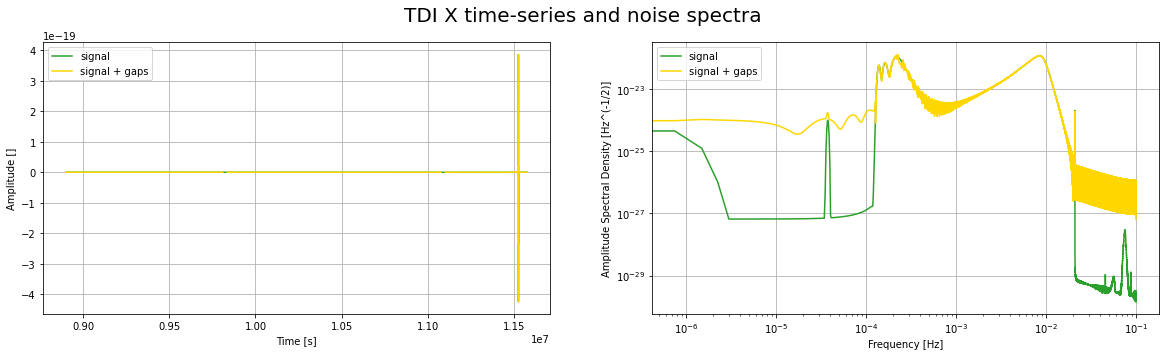

In [11]:
# plot TDI X
fig, ax = plt.subplots(1, 2, figsize=(20,5))
# top left canvas
ax[0].plot(tdi_sky['t'][skip:], tdi_sky["X"][skip:], label='signal', color='tab:green')
ax[0].plot(tdi_sky_gapped['t'][skip:], tdi_sky_gapped["X"][skip:], label='signal + gaps', color='gold')
# ax[0].plot(tdi_noise_gapped['t'][skip:], gapdiff, label='noise + gaps + signal', color='tab:blue')
ax[0].set_ylabel("Amplitude []")
ax[0].set_xlabel("Time [s]")
ax[0].grid()
ax[0].legend()
# top right canvas
f, psdX =  scipy.signal.welch(tdi_sky["X"][skip:], fs=1.0/dt, window='nuttall', nperseg=ndata/2)
ax[1].loglog(f, np.sqrt(psdX),label = 'signal', color='tab:green')

tdiskygapped_wo_nan = tdi_sky_gapped["X"].copy()
tdiskygapped_wo_nan[np.isnan(tdi_ts['X'])] = 0 # set to 0 to compute PSD
f, psdXgap =  scipy.signal.welch(tdiskygapped_wo_nan[skip:], fs=1.0/dt, window='nuttall', nperseg=ndata/2)
ax[1].loglog(f, np.sqrt(psdXgap),label = 'signal + gaps', color='gold')
ax[1].set_ylabel("Amplitude Spectral Density [Hz^(-1/2)]")
ax[1].set_xlabel("Frequency [Hz]")
ax[1].grid()
ax[1].legend()

plt.suptitle('TDI X time-series and noise spectra',fontsize=20)

## 2. Build orthogonal TDI combinations

### 2.1. Build orthogonal TDI combinations for `n+s` data. 

Check that explicit evaluation of orthogonal TDI combinations is equivalent to evaluation inside LDC functions.

In [283]:
# load tdi A, E, T
times = tdi_clean['t'][skip:]

A = (tdi_clean['Z'][skip:] - tdi_clean['X'][skip:])/np.sqrt(2)

E = (tdi_clean['X'][skip:] - 2*tdi_clean['Y'][skip:] + tdi_clean['Z'][skip:])/np.sqrt(6)

T = (tdi_clean['X'][skip:] + tdi_clean['Y'][skip:] + tdi_clean['Z'][skip:])*float(1./np.sqrt(3))

datans = np.rec.fromarrays([tdi_clean['t'][skip:], A, E, T], 
                         names = ['t', 'A', 'E', 'T'])

Compare my evaluation to LDC conversion function, just to be on the safe side of things.

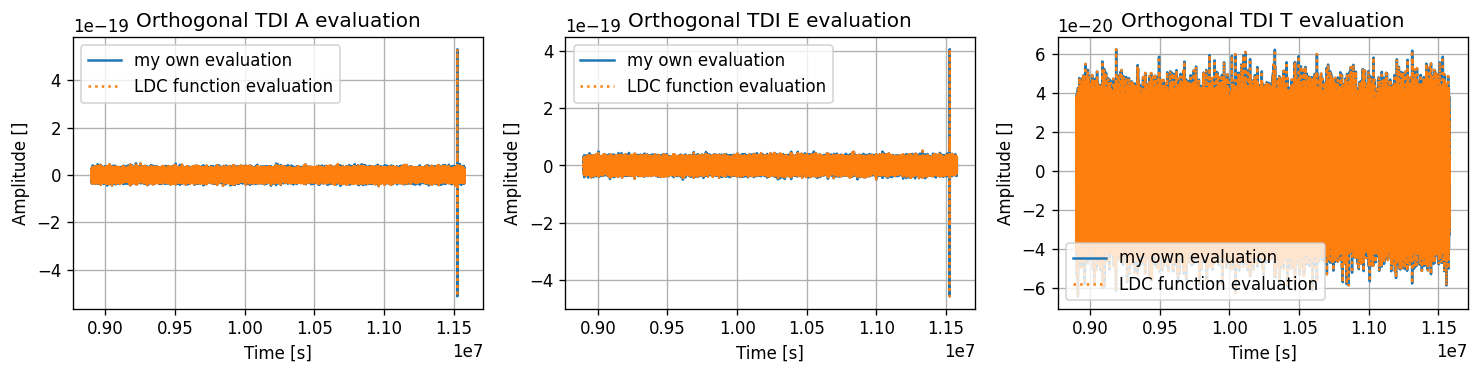

In [284]:
clean_orto = TDI.load(fname, name="clean/tdi")
# clean_orto
clean_orto.XYZ2AET()

fig, ax = plt.subplots(1,3, figsize=(15,3),dpi=120)
for tdi in datans.dtype.names[1:]:
    ax[datans.dtype.names[1:].index(tdi)].set_title('Orthogonal TDI {tdi} evaluation'.format(tdi=tdi))
    ax[datans.dtype.names[1:].index(tdi)].plot(datans['t'][skip:], datans[tdi][skip:], label = 'my own evaluation')
    ax[datans.dtype.names[1:].index(tdi)].plot(clean_orto[tdi].coords['t'][skip:],clean_orto[tdi].values[skip:], ls =':', label = 'LDC function evaluation')
    ax[datans.dtype.names[1:].index(tdi)].set_xlabel('Time [s]')
    ax[datans.dtype.names[1:].index(tdi)].set_ylabel('Amplitude []')
    ax[datans.dtype.names[1:].index(tdi)].grid()
    ax[datans.dtype.names[1:].index(tdi)].legend()

### 2.2. Build orthogonal TDI combinations for `s`, `n`, `n+s+g` data. 


In [15]:
# load tdi A, E, T
times = tdi_sky['t'][skip:]

A = (tdi_sky['Z'][skip:] - tdi_sky['X'][skip:])/np.sqrt(2)
E = (tdi_sky['X'][skip:] - 2*tdi_sky['Y'][skip:] + tdi_sky['Z'][skip:])/np.sqrt(6)
T = (tdi_sky['X'][skip:] + tdi_sky['Y'][skip:] + tdi_sky['Z'][skip:])*float(1./np.sqrt(3))

datas = np.rec.fromarrays([tdi_sky['t'][skip:], A, E, T], 
                         names = ['t', 'A', 'E', 'T'])

In [16]:
# generate noise data
# load tdi A, E, T
times = tdi_noise['t'][skip:]

A = (tdi_noise['Z'][skip:] - tdi_noise['X'][skip:])/np.sqrt(2)
E = (tdi_noise['X'][skip:] - 2*tdi_noise['Y'][skip:] + tdi_noise['Z'][skip:])/np.sqrt(6)
T = (tdi_noise['X'][skip:] + tdi_noise['Y'][skip:] + tdi_noise['Z'][skip:])*float(1./np.sqrt(3))

datan = np.rec.fromarrays([tdi_noise['t'][skip:], A, E, T], 
                         names = ['t', 'A', 'E', 'T'])

In [17]:
# load tdi A, E, T
times = tdi_gapped['t'][skip:]

A = (tdi_gapped['Z'][skip:] - tdi_gapped['X'][skip:])/np.sqrt(2)
E = (tdi_gapped['X'][skip:] - 2*tdi_gapped['Y'][skip:] + tdi_gapped['Z'][skip:])/np.sqrt(6)
T = (tdi_gapped['X'][skip:] + tdi_gapped['Y'][skip:] + tdi_gapped['Z'][skip:])*float(1./np.sqrt(3))

datag = np.rec.fromarrays([tdi_gapped['t'][skip:], A, E, T], 
                         names = ['t', 'A', 'E', 'T'])

### 2.3. Define useful functions 

All these will end up in a separate file afterwards.

- `fft_olap_psd`: function that evaluates PSD equivalent to `scipy.signal.welch` and also evaluates FFT at the same time
- `generate_freq_data`: function that applies `fft_olap_psd` to each group inside data and groups results in a single `numpy.recarray` with the same structure of time-domain data.
- `plot_compare_spectra_timeseries`: modified version of `lisabeta_fill_gaps.plot_compare_spectra` function that plots noise spectra and distribution of real/imag part of PSD/noise_model

In [287]:
def generate_freq_data(data, tdi_vars = 'from_file'):
    '''
    Applies `fft_olap_psd` to each group inside data and groups results in a single `numpy.recarray` with the same structure of time-domain data.
    
    Parameters:
    -----------
        data : numpy rec-array 
            time-domain data whose fields are 't' for time-base 
            and 'A', 'E', 'T' for the case of orthogonal TDI combinations.
        tdi_vars : string
            Key identifying the name of TDI variables under analysis. Default is 'orthogonal', 
            resulting in 'A', 'E', 'T'. Other option is 'from_file', which acquires TDI names
            from time-series file. **** TO DO: uniform this
        
    Returns:
    --------
        fdata : numpy rec-array  
            frequency domain fft data whose fields are 'f' for freq-base 
            and 'A', 'E', 'T' for the case of orthogonal TDI combinations.
        psddata : numpy rec-array 
            frequency domain psd data whose fields are 'f' for freq-base 
            and 'A', 'E', 'T' for the case of orthogonal TDI combinations.
        fftscalefac : float
    '''
    # tdi label names
    if tdi_vars == 'orthogonal': 
        names = ['A', 'E', 'T']
    elif tdi_vars == 'from_file':
        names = data.dtype.names[1:]
    
    fdata = np.recarray(shape = (np.int32(data.shape[0]/2+1),), 
                       dtype={'names':('f',)+names, 'formats':[np.float64]+3*[np.complex128]})
    psddata = np.recarray(shape = (np.int32(data.shape[0]/2+1),), 
                       dtype={'names':('f',)+names, 'formats':[np.float64]+3*[np.complex128]})
    for tdi in names:
        f, psd, fft, fftscalefac = fft_olap_psd(data, chan = tdi)
        fdata[tdi] = fft
        psddata[tdi] = psd
    fdata['f'] = f
    psddata['f'] = f
    
    return fdata, psddata, fftscalefac

def fft_olap_psd(data_array, chan=None, fs=None, navs = 1, detrend = True, scale_by_freq = True, plot = False):
    '''
    Evaluates one-sided FFT and PSD of time-domain data.
    
    Parameters:
    -----------
        data_array : numpy rec-array 
            time-domain data whose fields are 't' for time-base 
            and 'A', 'E', 'T' for the case of orthogonal TDI combinations.
        channel : str
            single channel name 
        navs : int
            number of averaging segments used to evaluate fft
            *** TO DO: implement navs > 1
        detrend : bool
            apply detrending of data
        scale_by_freq : bool
            scale data by frequency
        plot : bool
            plot comparison between PSD and scipy.signal.welch evaluation
        
    Returns:
    --------
        fft_freq : numpy array
            array of frequencies
        PSD_own : numpy array
            array of PSD
        fft_WelchEstimate_oneSided : numpy array
            array of fft values
        scalefac : float
            scale factor to convert fft^2 values into PSD
    '''
    # Number of segments
    ndata = data_array.shape[0]
    if fs is None:
        if data_array.dtype.names: 
            dt = data_array['t'][1]-data_array['t'][0]
        else: # assume dt is 5 seconds
            raise ValueError("Specify the sampling frequency of data using keyword fs, e.g. fs = 0.01 ")
        fs = 1/dt
    if chan is None:
        if not data_array.dtype.names: 
            data = data_array
        else:
            raise ValueError("Specify a channel name using keyword chan, e.g. chan = 'A' ")
    elif type(chan) is str:
        data = data_array[chan]
            
    overlap_fac = 0.5
    navs = navs
    segment_size = np.int32(ndata/navs) # Segment size = 50 % of data length
    window = signal.hann(segment_size) # Hann window
    # signal.welch
    f, Pxx_spec = signal.welch(data, fs=fs, window='hanning', 
                               detrend='constant',average='mean',nperseg=segment_size)

    ## Own implementation
    # Number of segments
    overlap_fac = 0.5
    baseSegment_number = np.int32(ndata/segment_size) # Number of initial segments
    total_segments =  np.int32(baseSegment_number + ((1-overlap_fac)**(-1) - 1 ) * (baseSegment_number - 1)) # No. segments including overlap
    overlap_size = overlap_fac*segment_size
    fft_size = segment_size
    detrend = True # If true, removes signal mean
    scale_by_freq = True
    # PSD size = N/2 + 1 
    PSD_size = np.int32(fft_size/2)+1

    if scale_by_freq:
        # Scale the spectrum by the norm of the window to compensate for
        # windowing loss; see Bendat & Piersol Sec 11.5.2.
        S2 = np.sum((window)**2) 
    else:
        # In this case, preserve power in the segment, not amplitude
        S2 = (np.sum(window))**2

    fft_segment = np.empty((total_segments,fft_size),dtype=np.complex64)
    for i in range(total_segments):
        offset_segment = np.int32(i* (1-overlap_fac)*segment_size)
        current_segment = data[offset_segment:offset_segment+segment_size]
        # Detrend (Remove mean value)   
        if detrend :
            current_segment = current_segment - np.mean(current_segment)
        windowed_segment = np.multiply(current_segment,window)
        fft_segment[i] = np.fft.fft(windowed_segment,fft_size) # fft automatically pads if n<nfft

    # Add FFTs of different segments
    fft_sum = np.zeros(fft_size,dtype=np.complex128)
    for segment in fft_segment:
         fft_sum += segment

    # Signal manipulation factors      

    # Normalization including window effect on power
    powerDensity_normalization = 1/S2
    # Averaging decreases FFT variance
    powerDensity_averaging = 1/total_segments
    # Transformation from Hz.s to Hz spectrum
    if scale_by_freq:
        powerDensity_transformation = 1/fs
    else:
        powerDensity_transformation = 1
    # assess scale factor    
    scalefac = powerDensity_averaging * powerDensity_normalization * powerDensity_transformation
    # Make oneSided estimate 1st -> N+1st element
    fft_WelchEstimate_oneSided = fft_sum[0:PSD_size]
    # Convert FFT values to power density in U**2/Hz
    PSD_own = np.square(np.abs(fft_WelchEstimate_oneSided)) * scalefac
    # Double frequencies except DC and Nyquist
    PSD_own[2:PSD_size-1] *= 2
    fft_freq = np.fft.rfftfreq(fft_size, 1/fs)
    # Take absolute value of Nyquist frequency (negative using np.fft.fftfreq)
    fft_freq[-1] = np.abs(fft_freq[-1])

    if plot:
        fig, ax = plt.subplots(1,1, dpi = 120)
        # plt.loglog(data_fft['f'], np.sqrt(scalefac*ps), label='fft')
        ax.loglog(fft_freq, (PSD_own), label = 'my own',ls='-')
        ax.loglog(f, (Pxx_spec), label = 'welch',ls='--')
        # ax.loglog(freq, (PSD_own), label = 'own',ls='-')
        ax.set_xlabel('frequency [Hz]')
        ax.set_ylabel('Linear spectrum [V RMS]')
        ax.set_title('Power spectrum (sciy.signal.welch)')
        ax.legend()
        ax.set_xlim([f[1], dt/2])
        ax.grid()
    return fft_freq, PSD_own, fft_WelchEstimate_oneSided, scalefac

###### define compare spectra function for time-series
from scipy.stats import norm

def plot_compare_spectra_timeseries(data, noise_models, fmax = 2e-2, tdi_vars = 'orthogonal', labels = ['Signal + Noise','Noise','Signal']):
    '''
    A utility for plotting spectral comparisons starting from time-domain data instead
    of frequency-domain data.
    
    Parameters:
    -----------
        data : numpy rec-array 
            time-domain data whose fields are 't' for time-base 
            and 'A', 'E', 'T' for the case of orthogonal TDI combinations.
        noise_models : list of arrays
            PSD of noise model pertaining to the data under analysis. 
            Evaluated via the LDC get_noise_model function.     
        fmax : float scalar
            maximum frequency at which we want to cut the analysis. 
        tdi_vars : string
            Key identifying the name of TDI variables under analysis. Default is 'orthogonal', 
            resulting in 'A', 'E', 'T'. Other option is 'from_file', which acquires TDI names
            from time-series file. **** TO DO: uniform this
        
    Returns:
    --------
        grid plot of noise spectra compared with histogram of real and imaginary parts of the fft.
    '''
    # set max value of frequency
    fmax = fmax
    # tdi label names
    if tdi_vars == 'orthogonal': 
        names = ['A', 'E', 'T']
    elif tdi_vars == 'from_file':
        names = data.dtype.names[1:]
    # set up labels    
    data_labels = labels

    fig, axs = plt.subplots(3,len(noise_models),figsize=[19.2,12],dpi=120)
    for n in names[:len(noise_models)]: 
        ax = axs[0,names.index(n)]
        ax.set_title(r"Channel "+(n))
        ax.set_xlabel(r"Frequency [Hz]")
        ax.set_ylabel("sqrt(PSD) [1/Hz]") 
        idx = 0
        for d in data:
            f, psd, fft, _ = fft_olap_psd(d, chan = n)
            ax.loglog(f[f<fmax], np.sqrt(psd[f<fmax]), label=data_labels[idx])
            idx += 1
        ax.loglog(f[f<fmax], np.sqrt(noise_models[names.index(n)][f<fmax]), label=n+" PSD model")  
        ax.grid()
        ax.legend()

        # evaluate adherence of PDS to noise model data real part
        ax = axs[1,names.index(n)]
        
        # assess number of bins from noise data
        nbins = int(np.sqrt(len(fft[f<fmax])))
        # create linspace for gaussian noise
        x = np.linspace(-6,6,nbins)

    
        ax.set_xlabel('Real part deviation')
        ax.set_ylabel('Count density')
        idx = 0
        for d in data:
            _, _, fft, fft_scalefac = fft_olap_psd(d, chan = n)
            # set up scale factor for fft
            scalefac = np.sqrt(4*fft_scalefac)
            ax.hist(fft[f<fmax].real*scalefac/np.sqrt(noise_models[names.index(n)][f<fmax]),
                 bins = nbins,
                 density = True,
                 label = data_labels[idx])
            idx += 1
        ax.plot(x,norm.pdf(x), label='Normal distribution')
        ax.grid()
        ax.set_xlim([-6, 6])
        ax.legend()
        
        # evaluate adherence of PDS to noise model data real part
        ax = axs[2,names.index(n)]
        ax.set_xlabel('Imag part deviation')
        ax.set_ylabel('Count density')
        idx = 0
        for d in data:
            _, _, fft, fft_scalefac = fft_olap_psd(d, chan = n)
            # set up scale factor for fft
            scalefac = np.sqrt(4*fft_scalefac)
            ax.hist(fft[f<fmax].imag*scalefac/np.sqrt(noise_models[names.index(n)][f<fmax]),
                 bins = nbins,
                 density = True,
                 label = data_labels[idx])
            idx += 1
        ax.plot(x,norm.pdf(x), label='Normal distribution')
        ax.set_xlim([-6, 6])
        ax.grid()
        ax.legend()
        

### 2.4 Data quicklook
#### 2.4.1 Test PSD and FFT evaluation function

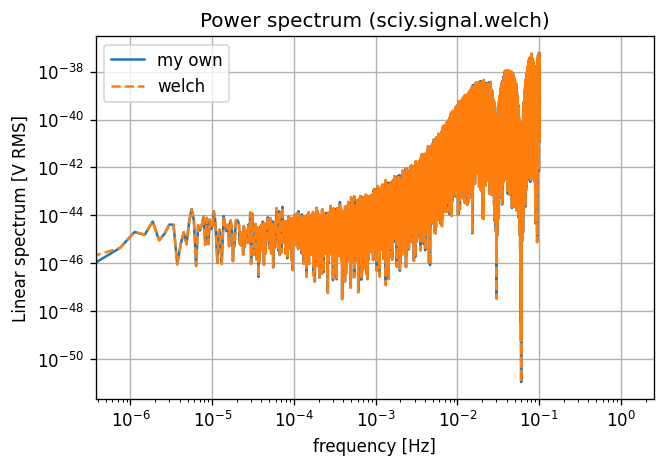

In [288]:
# Test psd and fft evaluation function
f, psdA, fft_A, _ = fft_olap_psd(datan, chan = 'A', plot = True)

#### 2.4.2 Define LISA noise model
Import noise model for Spritz data from LDC toolbox.

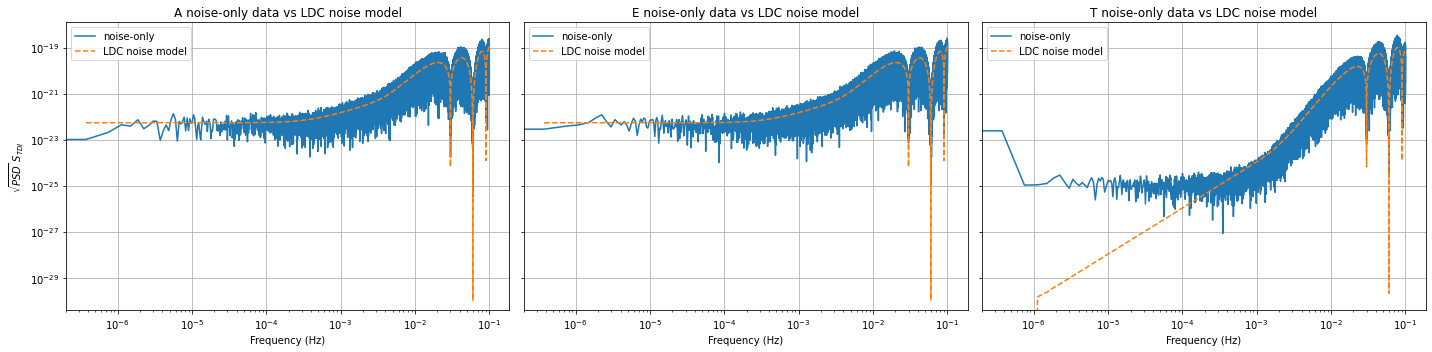

In [289]:
#Load some noise models from lisabeta
import lisabeta.lisa.pyLISAnoise as pyLISAnoise

LISAnoise={'InstrumentalNoise': 'SciRDv1', 
           'WDbackground': False, 
           'WDduration': 0.0, 
           'lowf_add_pm_noise_f0': 0.0, 
           'lowf_add_pm_noise_alpha': 2.0}
# LISAnoise={'InstrumentalNoise': 'Proposal', 
#            'WDbackground': True, 
#            'WDduration': 3.0, 
#            'lowf_add_pm_noise_f0': 0.0, 
#            'lowf_add_pm_noise_alpha': 2.0}

# eval psd of noise data
fdatan, psddatan, fftscalefac = generate_freq_data(datan)
# noise models for A, E, T 
noise_model = "spritz"
S = {}
Nmodel = get_noise_model(noise_model, fdatan['f'])
for tdi in ['A', 'E', 'T']:
    S[tdi] = Nmodel.psd(tdi2=True, option=tdi, freq=fdatan['f'])
# plot data
fig, ax = plt.subplots(1,3,figsize=(20,5),sharey=True)
for tdi in S.keys(): 
    ax[list(S.keys()).index(tdi)].set_title('{tdi} noise-only data vs LDC noise model'.format(tdi=tdi))
    ax[list(S.keys()).index(tdi)].loglog(fdatan['f'], np.sqrt(psddatan[tdi]), label='noise-only')
    ax[list(S.keys()).index(tdi)].loglog(fdatan['f'], np.sqrt(S[tdi]), ls='--', label='LDC noise model')
    ax[list(S.keys()).index(tdi)].set_xlabel('Frequency (Hz)')
    ax[list(S.keys()).index(tdi)].grid()
    ax[list(S.keys()).index(tdi)].legend()

ax[0].set_ylabel(r'$\sqrt{PSD}$ $S_{TDI}$')
fig.tight_layout()
# plt.suptitle('Comparison between TDI of noise-only Spritz data vs noise models');

#### 2.4.3 Plot comparison between spectra and FFT distribution

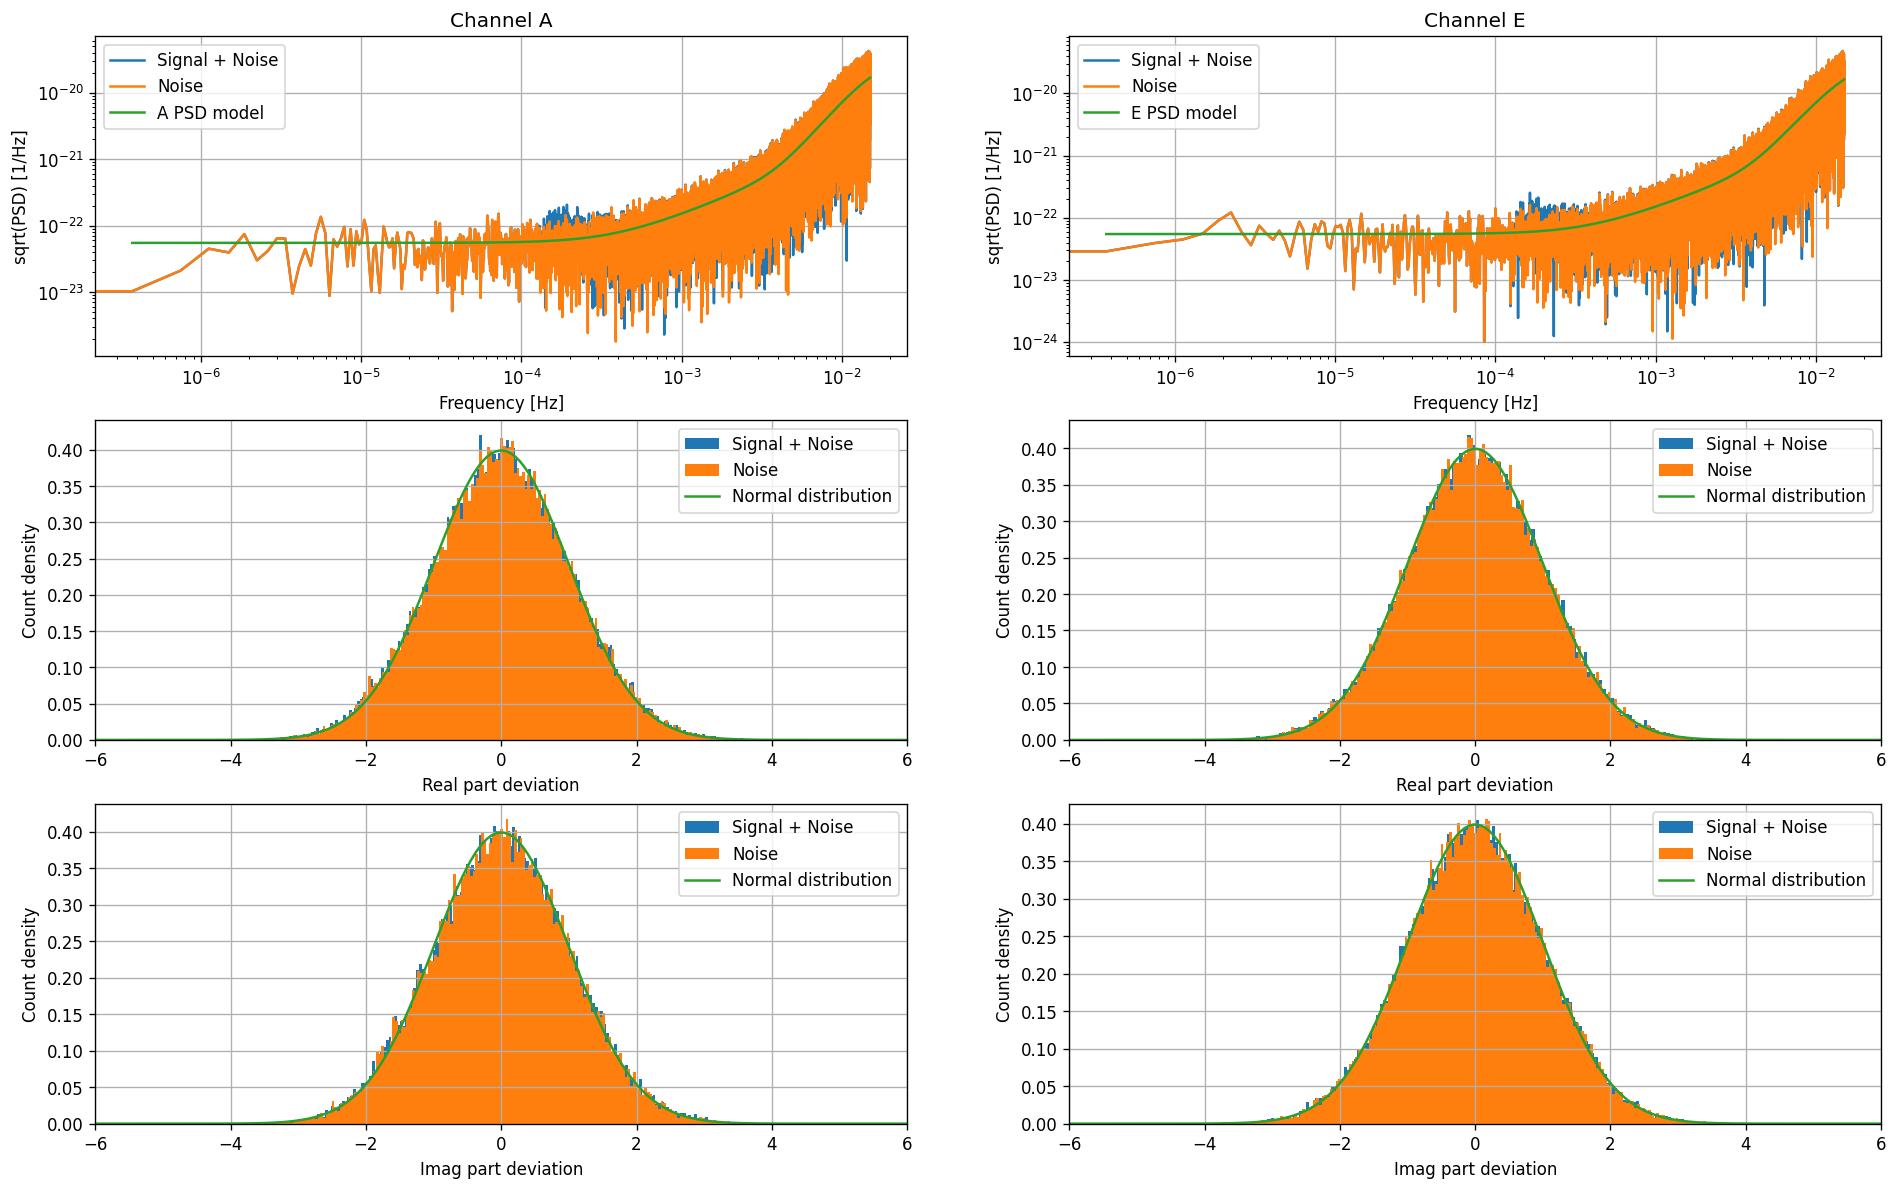

In [291]:
fmax = 1.5e-2
plot_compare_spectra_timeseries(data = [datans, datan], 
                                noise_models = [S.get(key) for key in ['A','E']], 
                                fmax = fmax)

## 3. Data pre-processing
Trying to apply the same data pre-processing treatment that has been applied to data in `MBHB_search_dev_globe.ipynb`.

We're gonna:
- Downsample and downaverage the data to avoid aliasing
    - Avoid downsampling by selecting single samples
    - Better to be averaging neighboring points

In [292]:
def downaverage(data, factor):
    avg=[]
    # downaveraging step
    for name in data.dtype.names[:]:
        avg += [np.convolve(data[name], np.ones(factor)/factor, mode='valid')]
    # downsampling with IIR filter to avoid aliasing
    avg[0]=avg[0][::factor]
    for i in range(1,len(avg)):
        avg[i] = scipy.signal.decimate(avg[i], factor)
 
    return np.rec.fromarrays(avg, names = data.dtype.names)

Shape of original data is (535580,) and is downaveraged down to (133895,)


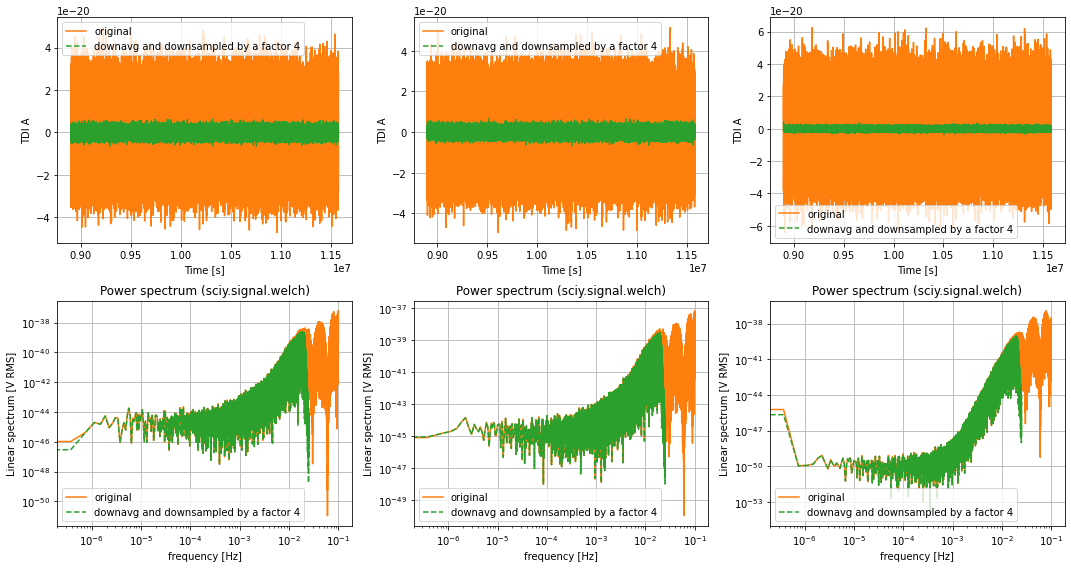

In [293]:
downfactor = 4

downavg = downaverage(datan,downfactor)

print("Shape of original data is " + str(datan.shape) + " and is downaveraged down to " + str(downavg.shape))

# fdatan, psddatan, fftscalefac = generate_freq_data(datan)
fdatan_da, psddatan_da, fftscalefac_da = generate_freq_data(downavg)

fig, ax = plt.subplots(2,3,figsize=(15,8))

for tdi in S.keys(): 
    ax[0][list(S.keys()).index(tdi)].plot(datan['t'],datan[tdi], label = 'original',color='tab:orange')
    ax[0][list(S.keys()).index(tdi)].plot(downavg['t'],downavg[tdi],label = 'downavg and downsampled by a factor {0:d}'.format(downfactor),ls='--', color='tab:green')
    ax[0][list(S.keys()).index(tdi)].grid()
    ax[0][list(S.keys()).index(tdi)].legend()
    ax[0][list(S.keys()).index(tdi)].set_xlabel('Time [s]')
    ax[0][list(S.keys()).index(tdi)].set_ylabel('TDI A')

    ax[1][list(S.keys()).index(tdi)].loglog(psddatan['f'], (psddatan[tdi]), label = 'original', ls='-', color='tab:orange')
    ax[1][list(S.keys()).index(tdi)].loglog(psddatan_da['f'], (psddatan_da[tdi]), label = 'downavg and downsampled by a factor {0:d}'.format(downfactor), ls='--', color='tab:green')
    ax[1][list(S.keys()).index(tdi)].set_xlabel('frequency [Hz]')
    ax[1][list(S.keys()).index(tdi)].set_ylabel('Linear spectrum [V RMS]')
    ax[1][list(S.keys()).index(tdi)].set_title('Power spectrum (sciy.signal.welch)')
    ax[1][list(S.keys()).index(tdi)].legend()
#     ax[1][list(S.keys()).index(tdi)].set_xlim([f[0], dt/2])
    ax[1][list(S.keys()).index(tdi)].grid()
fig.tight_layout()

## 4. Gap imputation with custom gaps

In [294]:
import bayesdawn.connect.lisabeta_fill_gaps as fill_gaps

Here we compare the full noise + signal dataset with the only-noise dataset, applying `LISAnoise` as noise model for the TDI noise spectra.

Note that `n + s` data do not deviate significantly from the Gaussian behavior for the orthogonal TDI combinations.

We have the expected Gaussian distribution behavior for $A$ and $E$, but not as much for $T$.

### 4.1 Noise-only `n` data
We'll first apply imputation to noise-only `n` data, then we'll move to `n + s`. 

We'll use downaveraged data to analyze this problem: instead of `datan` we'll use `datan_da`.
#### 4.1.1 Specify some short gaps and generate gapped data
Based on the `n` data, we are going to add some gaps to this data realization.

We're going to start with 3 small gaps 20-sample 100-seconds long as in the original notebook to test the code.

In [295]:
# reset time-series information data
ndata = downavg.shape[0]
dt = downavg['t'][1]-downavg['t'][0]
fs = 1/(downavg['t'][1]-downavg['t'][0])

print('ndata','dt', 'fs',sep='\t',end='\n---------------------\n')
print(ndata, dt, fs,sep='\t')

# fdatan, psddatan, fftscalefac = generate_freq_data(datan)
# fdatan_da, psddatan_da, fftscalefac_da = generate_freq_data(downavg)

ndata	dt	fs
---------------------
133895	20.0	0.05


In [296]:
#construct gap mask
mask = np.ones(ndata)
ts = np.arange(ndata) * dt

maskinfo = fill_gaps.construct_gap_mask(ndata,
                              n_gaps = 3,
                              gap_length = 100,
                              verbose = True)
mask = maskinfo['mask']

Defined gaps:
  gap0 (83753:83853)
  gap1 (11845:11945)
  gap2 (63310:63410)


In [297]:
data_masked = downavg.copy()

for names in downavg.dtype.names[1:]:
    data_masked[names] = mask * downavg[names]

for i in range(len(maskinfo['starts'])):
    print('gap', i,
          ':\n\tsamples:', maskinfo['starts'][i],
          '< i <', maskinfo['ends'][i], 
          '\n\tseconds:', ts[maskinfo['starts'][i]],
          '< t <', ts[maskinfo['ends'][i]])

gap 0 :
	samples: 83753 < i < 83853 
	seconds: 1675060.0 < t < 1677060.0
gap 1 :
	samples: 11845 < i < 11945 
	seconds: 236900.0 < t < 238900.0
gap 2 :
	samples: 63310 < i < 63410 
	seconds: 1266200.0 < t < 1268200.0


#### 4.1.2. Define function to visualize gaps in time-domain

Slightly modified version of `lisabeta_fill_gaps.view_gaps`.

In [311]:
def view_gaps(ts,ys,maskinfo,nwing=20,labels=None):
    '''
    A development utility for making plots of the gap relevant data
    '''
    gapstarts=maskinfo['starts']
    gapends=maskinfo['ends']
    n=len(gapstarts)
    nchan=len(ys[0])
    names=['A', 'E', 'T']
    
#     fig, axs = plt.subplots(nchan*2,n,figsize=[6.4*n,4.8*nchan*2],squeeze=False)
    # create figure
    fig = plt.figure(figsize=[5*n,4*nchan*2],constrained_layout=True)
#     fig.suptitle('View gaps')
    # create 3x1 subfigures for each channel
    subfigs = fig.subfigures(nrows = nchan, ncols = 1)
    
    for chan, subfig in enumerate(subfigs):
        subfig.suptitle(f'Channel {names[chan]}', size = 'xx-large')
        # create 2xn subplots per subfig
        axs = subfig.subplots(nrows = 2, ncols = n, sharey=True)
        for j in range(2):
            for i in range(n):
                i0 = gapstarts[i]-nwing
                iend = gapends[i]+nwing
                ax = axs[j][i]
                if j==0:
                    ax.set_prop_cycle(cycler(color=list(mcolors.TABLEAU_COLORS.keys())[:3],linestyle=['-','-',':']))
                    for yi in ys:
                        ax.plot(ts[i0:iend],yi[chan][i0:iend])
                    # ax.plot(ts[i0:iend],np.abs(ys[0][j][i0:iend]))
                    if labels is not None: ax.legend(labels=labels)
                else:
                    ax.set_prop_cycle(cycler(color=['tab:purple', 'tab:cyan'], linestyle=['-', ':']))
                    for yi in ys[1:]:
                        ax.plot(ts[i0:iend],yi[chan][i0:iend]-ys[0][chan][i0:iend])
                    if labels is not None: ax.legend(labels=['gap = '+l+' - '+labels[0] for l in labels[1:]])    
                ax.grid()
                ax.set_xlabel('Time [s]')
                ax.set_ylabel('Ampitude []')

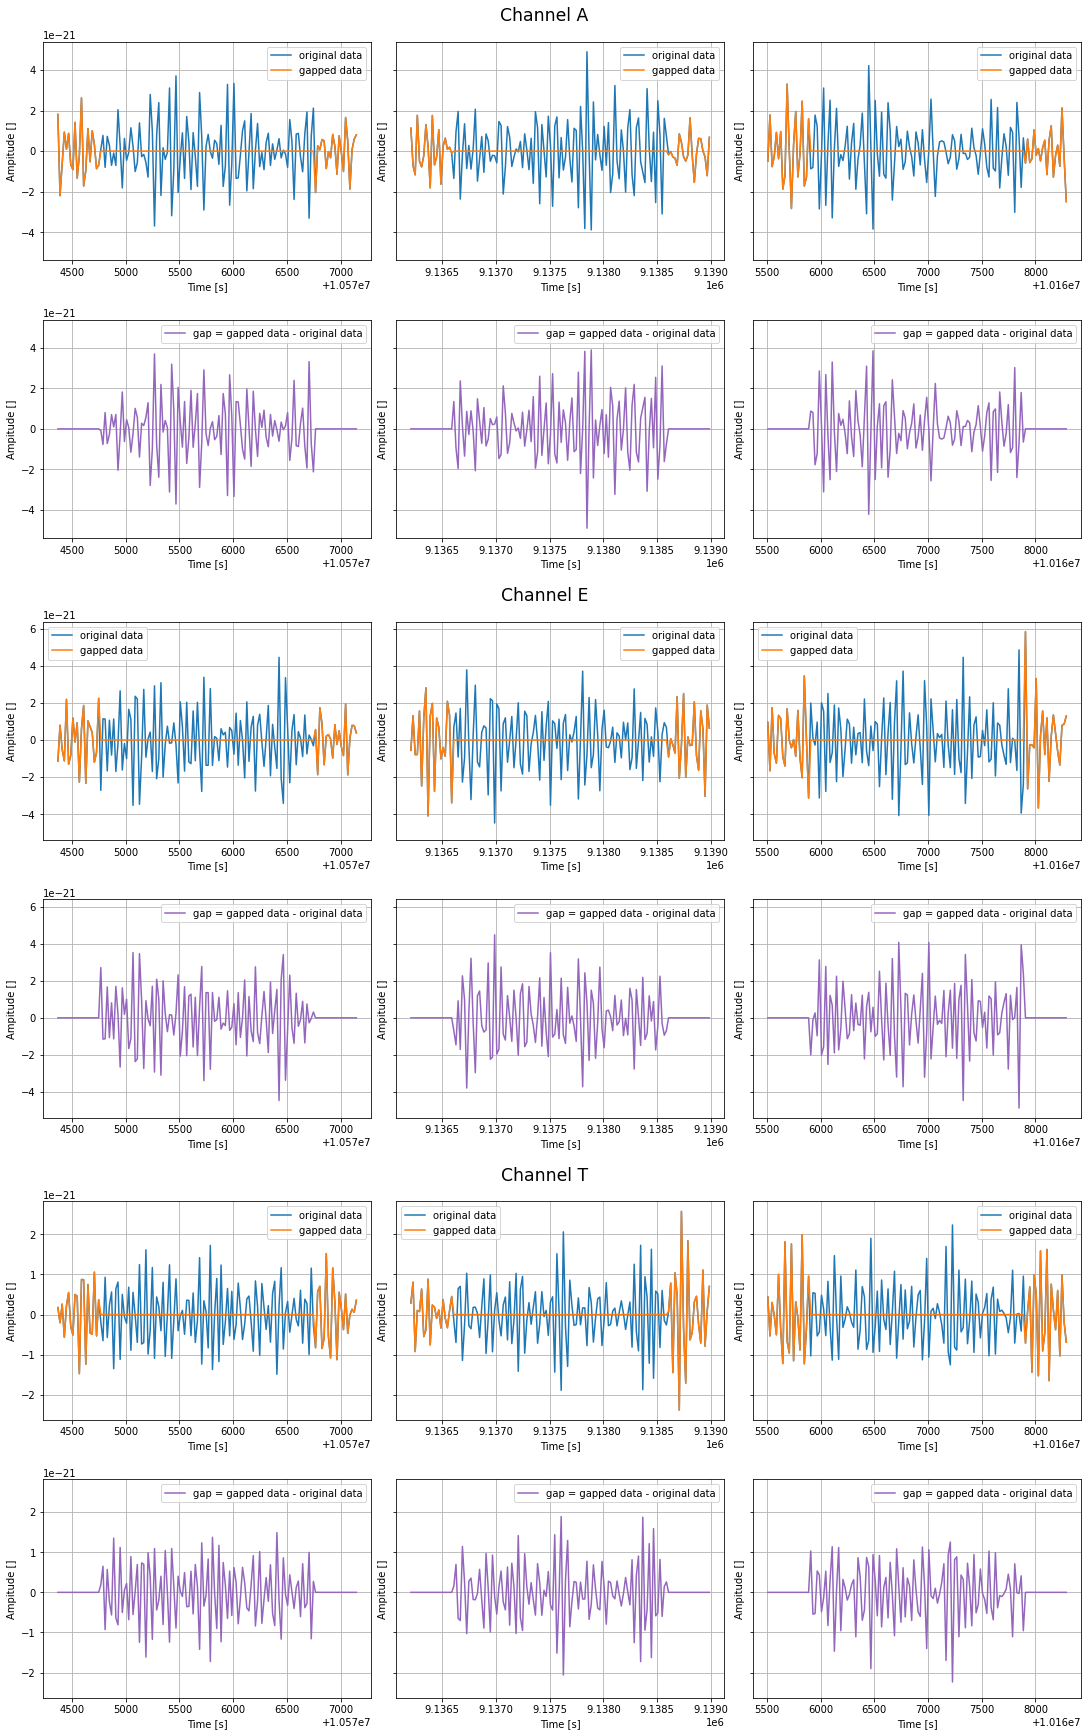

In [312]:
view_gaps(downavg['t'],
          [[downavg[names] for names in downavg.dtype.names[1:]], 
           [data_masked[names] for names in downavg.dtype.names[1:]]],
          maskinfo,
          labels=['original data', 'gapped data'])

#### 4.1.3 Set up PSD Spritz noise model

We'll end up not using this noise model in the gap imputation, but this might be useful for other purposes (or once the Spritz noise model is fixed).

In [313]:
# Embed the PSD function in a class
# psdmodel is imported from bayesdawn
class LDCspritzPSD(psdmodel.PSD):
    '''
    Specialization of the bayesdawn psd model class which connects LDC noise models to lisabeta PSD models.
    
    Parameters
    ----------
    n_data : array_like
        vector of size N_DSP continaing the noise DSP calculated at frequencies
        between -fe/N_DSP and fe/N_DSP where fe is the sampling frequency and N
        is the size of the time series (it will be the size of the returned
        temporal noise vector b)
    fs : scalar integer
        Size of the output time series
    noise_model : scalar float
        sampling frequency
    channel : string
        seed of the random number generator

    Returns
    -------
        bf : numpy array
        frequency sample of the colored noise (size N)
    '''

    def __init__(self, ndata, fs, noise_model, channel, fmin=None, fmax=None):
        # instantiates the PDS estimator from function psdmodel.PSD
        self.noise_model = noise_model
        self.channel = channel
        psdmodel.PSD.__init__(self, ndata, fs, fmin=None, fmax=None)
        if fmax is not None:
            self.f = self.f[self.f<fmax]


    def psd_fn(self, x):
        # returns the psd function defined earlier   
        Nmodel = get_noise_model(self.noise_model, x)
        return Nmodel.psd(tdi2=True, option=self.channel, freq=x)
    
# Instantiate the psd class
# psd_cls = LDCspritzPSD(ndata, fs, noise_model='spritz', channel='A', fmax = 1.5e-2)

Let's take a look at the model w.r.t downaveraged data.

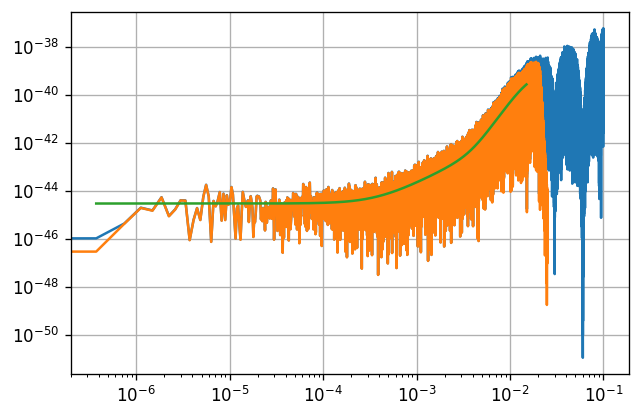

In [314]:
# instantiate the PSD noise class
psd_cls = []
for tdi in ['A', 'E', 'T']:
    psd_cls.append(LDCspritzPSD(ndata, fs, noise_model = 'spritz', channel = tdi, fmax = 15e-3))
# evaluate periodogram of data
flp, psdAlp, fftA, _ = fft_olap_psd(downavg, chan = 'A')
#compare with original data 
fig,ax=plt.subplots(1,1,dpi=120)
ax.loglog(psddatan['f'],psddatan['A'])
ax.loglog(flp,psdAlp)
ax.loglog(psd_cls[0].f, psd_cls[0].psd_fn(psd_cls[0].f))
ax.grid()

#### 4.1.4 PSD estimation 

Instead of using the full Spritz data model, we're going to estimate the PSD model from the data during the imputation process.

In [315]:
### Observation time
t_obs = ndata / fs
# Lower limit of frequency for the PSD estimation
fmin = 1 / t_obs * 1.05
# Upper limit of frequency
fmax = fs/2
# Instantiate PSD estimator class
psd_cls = []
for tdi in ['A', 'E', 'T']:
    psd_cls.append(psdmodel.PSDSpline(ndata, fs,
                                n_knots=20,
                                d=3,
                                fmin=fmin,
                                fmax=fmax,
                                ext=0))


Let's take a look at the PSD estimated from data.

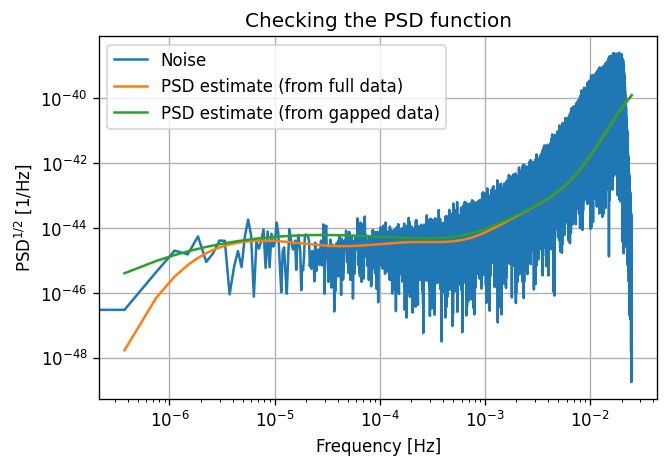

In [316]:
# define tdi names
names = ['A', 'E', 'T']
# create empty arrays
psd_estimate=[]
psd_estimate_gaps=[]
# evaluate fft and periodograms
fdatan_da, psddatan_da, fftscalefac_da = generate_freq_data(downavg)
fdatan_m, psddatan_m, fftscalefac_m = generate_freq_data(data_masked)
# perform PSD estimation
for i in range(3):
    tdi = names[i]
    # Do an estimation of the PSD on the full data
    psd_cls[i].estimate_from_periodogram(psddatan_da[tdi])
    psd_estimate.append(psd_cls[i].calculate(psddatan_da['f']))   
    # But in real-world situation we only have access to the masked data
    psd_cls[i].estimate_from_periodogram(psddatan_m[tdi])
    psd_estimate_gaps.append(psd_cls[i].calculate(psddatan_m['f']))

# Plot data against PSD
fig, ax = plt.subplots(dpi=120)
ax.set_title(r"Checking the PSD function")
ax.set_xlabel(r"Frequency [Hz]")
ax.set_ylabel(r"PSD${}^{1/2}$ [1/Hz]") 
ax.loglog(psddatan_da['f'], psddatan_da['A'], label="Noise")
ax.loglog(psddatan_da['f'], (psd_estimate[0]), label="PSD estimate (from full data)")
ax.loglog(psddatan_da['f'], (psd_estimate_gaps[0]), label="PSD estimate (from gapped data)")
ax.grid()
plt.legend()
plt.show()

#### 4.1.5. Perform data imputation on `n` data with custom short gaps

In [317]:
# create empty arrays for the imputation
imp_cls = []
psd_cls = []
y_res = []
# set up flags and variables
mask = maskinfo['mask']
PSD_ESTIMATION = True
data_rec = data_masked.copy()

# instantiate the PSD noise class
if PSD_ESTIMATION:
    for tdi in names:
        #psd_cls.append(chanPSD(nt, df, i, LISAnoise, f0=fs[10])) 
        psd_cls.append(psdmodel.PSDSpline(ndata, fs,
                                    n_knots=20,
                                    d=3,
                                    fmin=fmin,
                                    fmax=fmax,
                                    ext=0))
else:
    for tdi in names:
        psd_cls.append(LDCspritzPSD(ndata, fs, noise_model = 'spritz', channel = tdi, fmax = 15e-3))
    
    
# Perform data imputation
### NB this can be streamlined a little bit more and/or transformed into a function 
for tdi in range(len(names)):
    y_masked = data_masked[names[tdi]]
    s = np.zeros(len(mask))  #for residual 'signal' is zero
    # instantiate imputation class
    imp_cls += [datamodel.GaussianStationaryProcess(s, mask, psd_cls[tdi], method='nearest', na=50*fs, nb=50*fs)]
    # Number of iterations
    n_iter = 6
    # Initialize the (reconstructed) data residuals
    y_res = np.squeeze(np.array(y_masked).T) # (ymasked - s)
    f, psdy, _, _ = fft_olap_psd(y_res, fs = fs)
    for i in range(n_iter):
        t1 = time.time()
        if PSD_ESTIMATION:
            # Estimate PSD from reconstructed data residuals
            psd_cls[tdi].estimate_from_periodogram(psdy)
        # Pass the updated PSD model to the imputation class
        imp_cls[tdi].update_psd(psd_cls[tdi])
        # Re-compute of PSD-dependent terms
        imp_cls[tdi].compute_offline()
        # Imputation of missing data by randomly drawing from their conditional distribution
        y_rec = imp_cls[tdi].impute(y_masked, draw=True)
        # Update the data residuals
        data_rec[names[tdi]] = y_rec
        t2 = time.time()
        print("The imputation / PSD estimation for combination " + names[tdi] + " in iteration "+ str(i) +" took " + str(t2-t1))

Computation of autocovariance + PSD took 0.03990602493286133
The imputation / PSD estimation for combination A in iteration 0 took 0.06376385688781738
Computation of autocovariance + PSD took 0.04517722129821777
The imputation / PSD estimation for combination A in iteration 1 took 0.06640887260437012
Computation of autocovariance + PSD took 0.038831233978271484
The imputation / PSD estimation for combination A in iteration 2 took 0.05550122261047363
Computation of autocovariance + PSD took 0.038512229919433594
The imputation / PSD estimation for combination A in iteration 3 took 0.05492115020751953
Computation of autocovariance + PSD took 0.041906118392944336
The imputation / PSD estimation for combination A in iteration 4 took 0.059079885482788086
Computation of autocovariance + PSD took 0.03859519958496094
The imputation / PSD estimation for combination A in iteration 5 took 0.05526590347290039
Computation of autocovariance + PSD took 0.0348973274230957
The imputation / PSD estimatio

Take a look at gaps after a single imputation

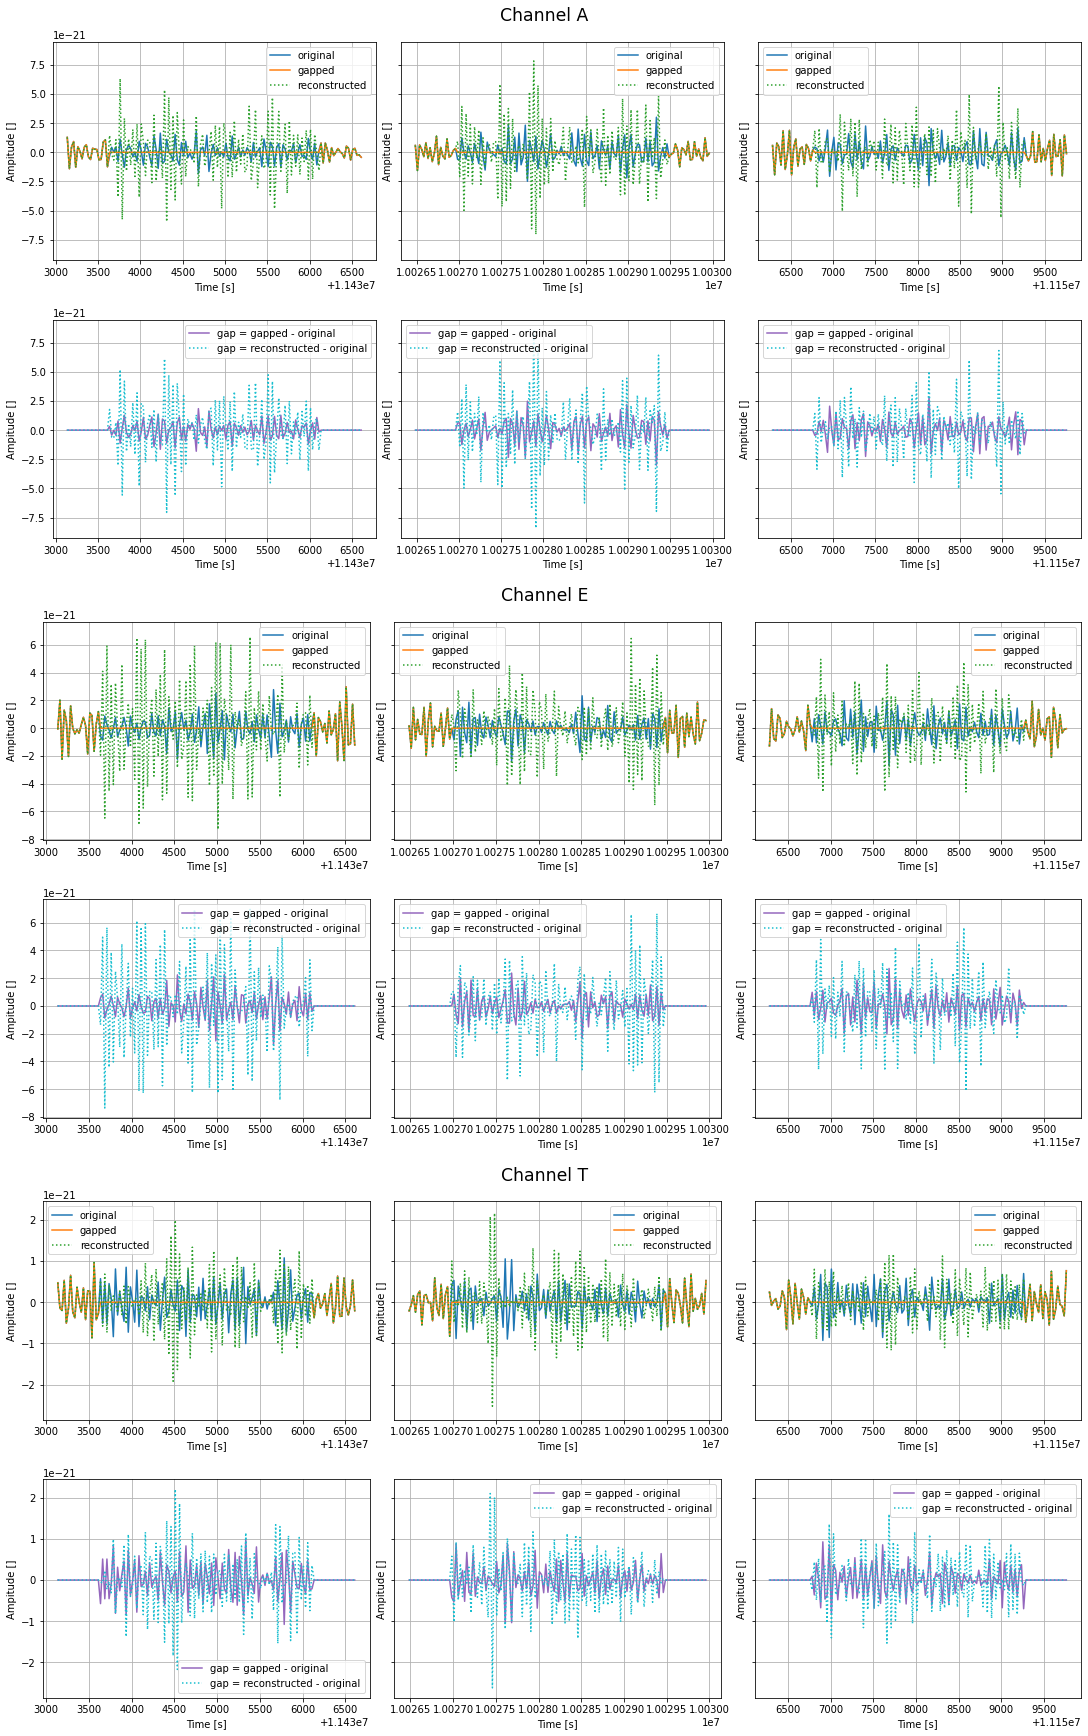

In [278]:
view_gaps(downavg['t'], 
          [[downavg[names] for names in downavg.dtype.names[1:]],
           [data_masked[names] for names in downavg.dtype.names[1:]], 
           [data_rec[names] for names in downavg.dtype.names[1:]]],
         maskinfo,
          labels=['original', 'gapped', 'reconstructed'])

In [318]:
# fdatan_da, psddatan_da, fftscalefac_da = generate_freq_data(downavg)
fdatan_rec, psddatan_rec, fftscalefac_rec = generate_freq_data(data_rec)
names = ['A', 'E', 'T']

psd_cls = []
for tdi in ['A', 'E', 'T']:
    #psd_cls.append(chanPSD(nt, df, i, LISAnoise, f0=fs[10])) 
    psd_cls.append(psdmodel.PSDSpline(ndata, fs,
                                n_knots=20,
                                d=3,
                                fmin=fmin,
                                fmax=fmax,
                                ext=0))
psd_estimate=[]
for i in range(3):
    tdi = names[i]
    # Do an estimation of the PSD on the full data
    psd_cls[i].estimate_from_periodogram(psddatan_rec[tdi])
    psd_estimate.append(psd_cls[i].calculate(psddatan_rec['f']))
#     psd_cls.append(LDCspritzPSD(ndata, fs, noise_model = 'spritz', channel = tdi, fmax = fmax))

In [319]:
# noise models for A, E, T 
noise_model = "spritz"
S = {}
Nmodel = get_noise_model(noise_model, fdatan_rec['f'])
for tdi in ['A', 'E', 'T']:
    S[tdi] = Nmodel.psd(tdi2=True, option=tdi, freq=fdatan_rec['f'])

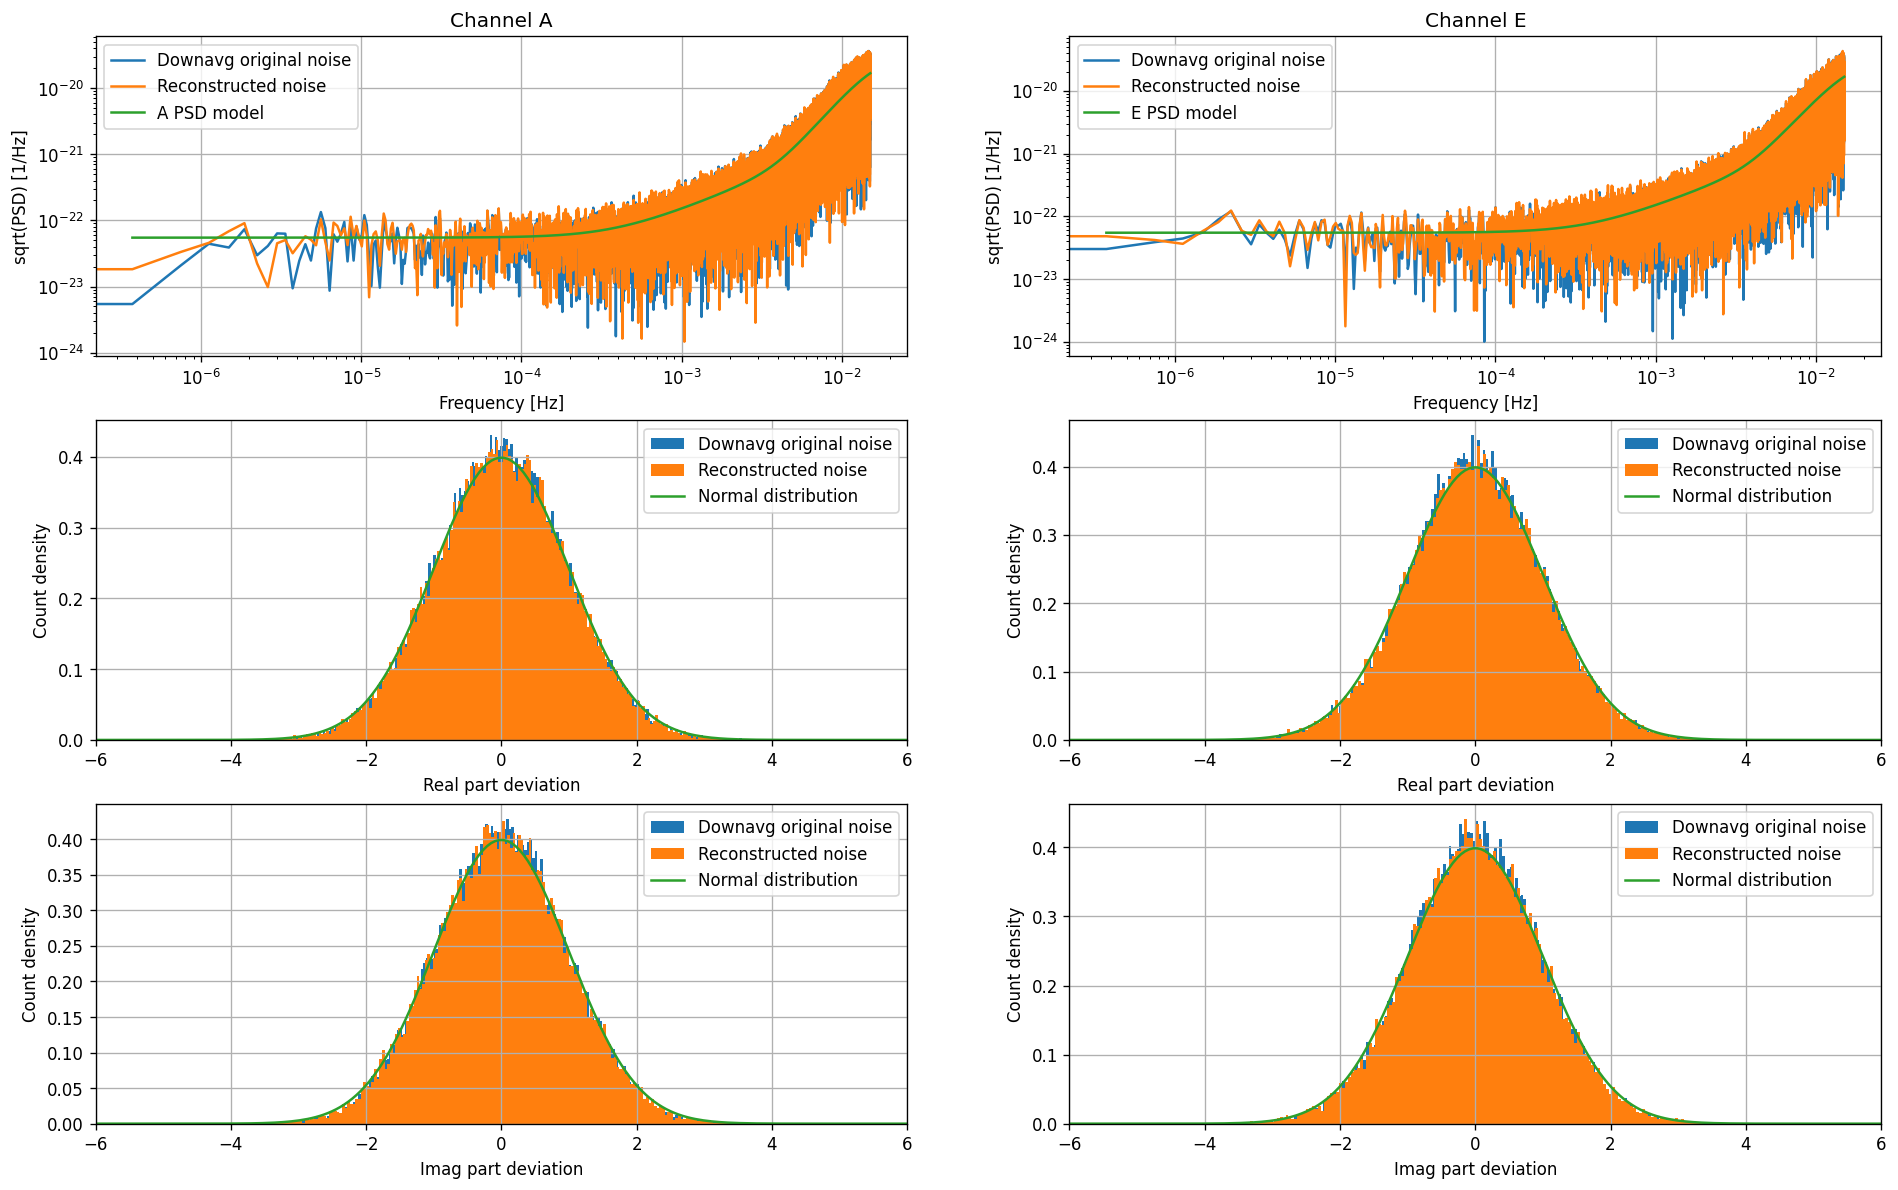

In [320]:
plot_compare_spectra_timeseries(data = [downavg, data_rec], 
                                noise_models = [S.get(key) for key in ['A','E']],
                                fmax = 1.5e-2,
                               labels = ['Downavg original noise', 'Reconstructed noise'])

## 4.2. Gap imputation on `n + s` data 

## 5. Analysis of Spritz gapped data